###### Imports

In [1]:
import requests
import urllib.request
from zipfile import ZipFile
import json
import io
import zipfile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import pandas as pd
import pysal as ps
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Bring in the TIGER file that we want and examine and clean for use

Specify the zipped shapefile url and read it in with geopandas, then display the info about the geodataframe including the size and datatypes.

In [2]:
#extract GeoDataFrame from Tiger
url= 'https://www2.census.gov/geo/tiger/TIGER2019/CBSA/tl_2019_us_cbsa.zip'
cbsa = gpd.read_file(url)
cbsa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CSAFP     550 non-null    object  
 1   CBSAFP    938 non-null    object  
 2   GEOID     938 non-null    object  
 3   NAME      938 non-null    object  
 4   NAMELSAD  938 non-null    object  
 5   LSAD      938 non-null    object  
 6   MEMI      938 non-null    object  
 7   MTFCC     938 non-null    object  
 8   ALAND     938 non-null    int64   
 9   AWATER    938 non-null    int64   
 10  INTPTLAT  938 non-null    object  
 11  INTPTLON  938 non-null    object  
 12  geometry  938 non-null    geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 95.4+ KB


Look at the crs.

In [3]:
cbsa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Make sure the data looks correct by displaying the head.

In [4]:
cbsa.head()

,CSAFP,CBSAFP,GEOID,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654601832,26140309,+33.9439840,-083.2138965,"POLYGON ((-83.53739 33.96591, -83.53184 33.968..."
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22494938651,387716575,+33.6937280,-084.3999113,"POLYGON ((-85.33823 33.65312, -85.33842 33.654..."
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438776649,301268696,+39.4693555,-074.6337591,"POLYGON ((-74.85675 39.42076, -74.85670 39.420..."
3,426,12120,12120,"Atmore, AL","Atmore, AL Micro Area",M2,2,G3110,2448115116,20504948,+31.1222867,-087.1684097,"POLYGON ((-87.61542 31.04100, -87.61541 31.041..."
4,258,12140,12140,"Auburn, IN","Auburn, IN Micro Area",M2,2,G3110,939731962,2657419,+41.4011894,-085.0001854,"POLYGON ((-85.19295 41.38001, -85.19296 41.381..."


## Bring in the population data using the Census API

###### The data we're curious about comes divided by sex or race - for now we're going to look at sex and then total them together because it's less data to deal with. You are only able to import 50 variables at once, so we're going to do total population and male population together, then female population. Eventually we will join them into one larger dataframe.

For duplication purposes, I'm going to create a list of variables and use string method .format() to iterate through the list to pull all of these variables, then I can copy paste that list into different notebooks where we're looking at different geographies. <-- come back to this... can't get the for loop right for now but ultimately will make it way better.

In [5]:
#male and total
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B01001_001E,B01001_002E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,B01001_008E,B01001_009E,B01001_010E,B01001_011E,B01001_012E,B01001_013E,B01001_014E,B01001_015E,B01001_016E,B01001_017E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key='+api_key

predicates= {}
get_vars= ["NAME","GEO_ID",'B01001_001E','B01001_020E','B01001_003E','B01001_004E','B01001_005E','B01001_006E','B01001_007E','B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E','B01001_013E','B01001_014E','B01001_015E','B01001_016E','B01001_017E','B01001_018E','B01001_019E','B01001_020E','B01001_021E','B01001_022E','B01001_023E','B01001_024E','B01001_025E']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
male= requests.get(url_str, params= predicates)

col_names = ['CBSA','GEOID','total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
            'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79','m80_84','m85+','ind']
male=pd.DataFrame(columns=col_names, data=male.json()[1:])

In [6]:
male.head()

,CBSA,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,m55_59,m60_61,m62_64,m65_66,m67_69,m70_74,m75_79,m80_84,m85+,ind
0,"Big Stone Gap, VA Micro Area",310M500US13720,42456,22025,1160,1149,1253,776,583,356,...,1465,768,853,425,861,858,559,340,335,13720
1,"Billings, MT Metro Area",310M500US13740,179071,88433,5510,6170,5862,3575,1936,774,...,6014,2780,3459,2176,3299,3299,2395,1420,1532,13740
2,"Binghamton, NY Metro Area",310M500US13780,241874,119221,6476,7128,6619,4518,4705,2593,...,9256,3942,4230,2808,3735,5025,4163,2167,2162,13780
3,"Birmingham-Hoover, AL Metro Area",310M500US13820,1085330,521496,34020,35330,36232,22069,12928,6687,...,34366,13750,18921,11914,15273,18629,11772,8176,6364,13820
4,"Bismarck, ND Metro Area",310M500US13900,127503,64036,4382,4386,4002,2228,1558,731,...,4350,1672,2137,1356,1865,2200,1477,940,1133,13900


In [7]:
#female
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B01001_026E,B01001_027E,B01001_028E,B01001_029E,B01001_030E,B01001_031E,B01001_032E,B01001_033E,B01001_034E,B01001_035E,B01001_036E,B01001_037E,B01001_038E,B01001_039E,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key='+api_key

predicates= {}
get_vars= ["NAME","GEO_ID",'B01001_026E','B01001_027E','B01001_028E','B01001_029E','B01001_030E','B01001_031E','B01001_032E','B01001_033E','B01001_034E','B01001_035E','B01001_036E','B01001_037E','B01001_038E','B01001_039E','B01001_040E','B01001_041E','B01001_042E','B01001_043E','B01001_044E','B01001_045E','B01001_046E','B01001_047E','B01001_048E','B01001_049E']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
female= requests.get(url_str, params= predicates)

col_names = ['CBSA','GEOID','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29','f30_34',
            'f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74','f75_79','f80_84','f85+','ind']
female=pd.DataFrame(columns=col_names, data=female.json()[1:])

In [8]:
female.head()

,CBSA,GEOID,ftotal,fu5,f5_9,f10_14,f15_17,f18_19,f20,f21,...,f55_59,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,ind
0,"Big Stone Gap, VA Micro Area",310M500US13720,20431,1054,1297,1012,702,447,345,172,...,1611,596,1047,740,646,947,638,573,535,13720
1,"Billings, MT Metro Area",310M500US13740,90638,5301,5588,6219,3210,1857,743,944,...,6679,2569,3502,2014,3357,4053,2710,2050,2697,13740
2,"Binghamton, NY Metro Area",310M500US13780,122653,6104,6196,6595,4263,4564,2517,2145,...,9712,3461,4673,3223,3893,5733,4678,3388,4736,13780
3,"Birmingham-Hoover, AL Metro Area",310M500US13820,563834,33618,34098,34317,20814,12937,7540,5998,...,38226,15788,21722,13729,17591,23233,16738,12956,12405,13820
4,"Bismarck, ND Metro Area",310M500US13900,63467,4146,4092,3839,2096,1629,739,590,...,4722,1729,2262,1505,1958,2316,1673,1550,2201,13900


Join all of these back together into one bigger df

In [9]:
age_pop = pd.merge(male, female, how = 'inner', on = 'GEOID')

In [10]:
age_pop.head()

,CBSA_x,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,f55_59,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,ind_y
0,"Big Stone Gap, VA Micro Area",310M500US13720,42456,22025,1160,1149,1253,776,583,356,...,1611,596,1047,740,646,947,638,573,535,13720
1,"Billings, MT Metro Area",310M500US13740,179071,88433,5510,6170,5862,3575,1936,774,...,6679,2569,3502,2014,3357,4053,2710,2050,2697,13740
2,"Binghamton, NY Metro Area",310M500US13780,241874,119221,6476,7128,6619,4518,4705,2593,...,9712,3461,4673,3223,3893,5733,4678,3388,4736,13780
3,"Birmingham-Hoover, AL Metro Area",310M500US13820,1085330,521496,34020,35330,36232,22069,12928,6687,...,38226,15788,21722,13729,17591,23233,16738,12956,12405,13820
4,"Bismarck, ND Metro Area",310M500US13900,127503,64036,4382,4386,4002,2228,1558,731,...,4722,1729,2262,1505,1958,2316,1673,1550,2201,13900


Check out our datatypes and any extra columns from the join that are no longer necessary.

In [11]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 938 entries, 0 to 937
Data columns (total 54 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CBSA_x  938 non-null    object
 1   GEOID   938 non-null    object
 2   total   938 non-null    object
 3   mtotal  938 non-null    object
 4   mu5     938 non-null    object
 5   m5_9    938 non-null    object
 6   m10_14  938 non-null    object
 7   m15_17  938 non-null    object
 8   m18_19  938 non-null    object
 9   m20     938 non-null    object
 10  m21     938 non-null    object
 11  m22_24  938 non-null    object
 12  m25_29  938 non-null    object
 13  m30_34  938 non-null    object
 14  m35_39  938 non-null    object
 15  m40_44  938 non-null    object
 16  m45_49  938 non-null    object
 17  m50_54  938 non-null    object
 18  m55_59  938 non-null    object
 19  m60_61  938 non-null    object
 20  m62_64  938 non-null    object
 21  m65_66  938 non-null    object
 22  m67_69  938 non-null    ob

Drop the indices and extra CBSA name column, rename the one you're going to keep, then convert all numeric columns to int64 as we're going to be performing mathematical operations on them.

In [12]:
#drop the indices and extra state name
age_pop = age_pop.drop(columns=['ind_x','CBSA_y','ind_y'])

In [13]:
#convert all numeric columns to integers
cols = ['total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+']

age_pop[cols]=age_pop[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [14]:
age_pop = age_pop.rename(columns={'CBSA_x':'CBSA'})

Check that the last few steps were effective.

In [15]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 938 entries, 0 to 937
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CBSA    938 non-null    object
 1   GEOID   938 non-null    object
 2   total   938 non-null    int64 
 3   mtotal  938 non-null    int64 
 4   mu5     938 non-null    int64 
 5   m5_9    938 non-null    int64 
 6   m10_14  938 non-null    int64 
 7   m15_17  938 non-null    int64 
 8   m18_19  938 non-null    int64 
 9   m20     938 non-null    int64 
 10  m21     938 non-null    int64 
 11  m22_24  938 non-null    int64 
 12  m25_29  938 non-null    int64 
 13  m30_34  938 non-null    int64 
 14  m35_39  938 non-null    int64 
 15  m40_44  938 non-null    int64 
 16  m45_49  938 non-null    int64 
 17  m50_54  938 non-null    int64 
 18  m55_59  938 non-null    int64 
 19  m60_61  938 non-null    int64 
 20  m62_64  938 non-null    int64 
 21  m65_66  938 non-null    int64 
 22  m67_69  938 non-null    in

Create columns of totals for each one of these age groups.

In [16]:
#create totals columns
age_pop['tu5'] = age_pop['mu5']+age_pop['fu5']
age_pop['t5_9'] = age_pop['m5_9']+age_pop['f5_9']
age_pop['t10_14'] = age_pop['m10_14']+age_pop['f10_14']
age_pop['t15_17'] = age_pop['m15_17']+age_pop['f15_17']
age_pop['t18_19'] = age_pop['m18_19']+age_pop['f18_19']
age_pop['t20'] = age_pop['m20']+age_pop['f20']
age_pop['t21'] = age_pop['m21']+age_pop['f21']
age_pop['t22_24'] = age_pop['m22_24']+age_pop['f22_24']
age_pop['t25_29'] = age_pop['m25_29']+age_pop['f25_29']
age_pop['t30_34'] = age_pop['m30_34']+age_pop['f30_34']
age_pop['t35_39'] = age_pop['m35_39']+age_pop['f35_39']
age_pop['t40_44'] = age_pop['m40_44']+age_pop['f40_44']
age_pop['t45_49'] = age_pop['m45_49']+age_pop['f45_49']
age_pop['t50_54'] = age_pop['m50_54']+age_pop['f50_54']
age_pop['t55_59'] = age_pop['m55_59']+age_pop['f55_59']
age_pop['t60_61'] = age_pop['m60_61']+age_pop['f60_61']
age_pop['t62_64'] = age_pop['m62_64']+age_pop['f62_64']
age_pop['t65_66'] = age_pop['m65_66']+age_pop['f65_66']
age_pop['t67_69'] = age_pop['m67_69']+age_pop['f67_69']
age_pop['t70_74'] = age_pop['m70_74']+age_pop['f70_74']
age_pop['t75_79'] = age_pop['m75_79']+age_pop['f75_79']
age_pop['t80_84'] = age_pop['m80_84']+age_pop['f80_84']
age_pop['t85+'] = age_pop['m85+']+age_pop['f85+']

In [17]:
age_pop.head(3)

,CBSA,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,t50_54,t55_59,t60_61,t62_64,t65_66,t67_69,t70_74,t75_79,t80_84,t85+
0,"Big Stone Gap, VA Micro Area",310M500US13720,42456,22025,1160,1149,1253,776,583,356,...,2636,3076,1364,1900,1165,1507,1805,1197,913,870
1,"Billings, MT Metro Area",310M500US13740,179071,88433,5510,6170,5862,3575,1936,774,...,11127,12693,5349,6961,4190,6656,7352,5105,3470,4229
2,"Binghamton, NY Metro Area",310M500US13780,241874,119221,6476,7128,6619,4518,4705,2593,...,16141,18968,7403,8903,6031,7628,10758,8841,5555,6898


## Create groups for analysis. Since we're looking at ageing services, it makes sense to group people into some rough "stage of life" that is predicated on services provided to them or their position in the workforce.

###### So we're going to do:  
- Under 5: this group needs childcare outside of the public school system  
- Over 5 but under 18: presumably in the school system  
- 18, 19, 20s: out of the school system, likely in college or in the workforce  
- 30s: beginning-mid career  
- 40s: established career  
- 50-64: height of career, then considering retirement  
- 65+: supposedly retiring, officially an older person? what's the term? eligible for medicaid. anyway.

In [18]:
#school is under 18, again for males, females, and total
age_pop['mschool']=age_pop['m5_9']+age_pop['m10_14']+age_pop['m15_17']
age_pop['fschool']=age_pop['f5_9']+age_pop['f10_14']+age_pop['f15_17']
age_pop['tschool']=age_pop['t5_9']+age_pop['t10_14']+age_pop['t15_17']

In [19]:
#18/19/20s
age_pop['m18_20s']=age_pop['m18_19']+age_pop['m20']+age_pop['m21']+age_pop['m22_24']+age_pop['m25_29']
age_pop['f18_20s']=age_pop['f18_19']+age_pop['f20']+age_pop['f21']+age_pop['f22_24']+age_pop['f25_29']
age_pop['t18_20s']=age_pop['t18_19']+age_pop['t20']+age_pop['t21']+age_pop['t22_24']+age_pop['t25_29']

In [20]:
#30s
age_pop['m30s']=age_pop['m30_34']+age_pop['m35_39']
age_pop['f30s']=age_pop['f30_34']+age_pop['f35_39']
age_pop['t30s']=age_pop['t30_34']+age_pop['t35_39']

In [21]:
#40s
age_pop['m40s']=age_pop['m40_44']+age_pop['m45_49']
age_pop['f40s']=age_pop['f40_44']+age_pop['f45_49']
age_pop['t40s']=age_pop['t40_44']+age_pop['t45_49']

In [22]:
#50 - 64
age_pop['m50_65']=age_pop['m50_54']+age_pop['m55_59']+age_pop['m60_61']+age_pop['m62_64']
age_pop['f50_65']=age_pop['f50_54']+age_pop['f55_59']+age_pop['f60_61']+age_pop['f62_64']
age_pop['t50_65']=age_pop['t50_54']+age_pop['t55_59']+age_pop['t60_61']+age_pop['t62_64']

In [23]:
#over 65
age_pop['mo65']=age_pop['m65_66']+age_pop['m67_69']+age_pop['m70_74']+age_pop['m75_79']+age_pop['m80_84']+age_pop['m85+']
age_pop['fo65']=age_pop['f65_66']+age_pop['f67_69']+age_pop['f70_74']+age_pop['f75_79']+age_pop['f80_84']+age_pop['f85+']
age_pop['to65']=age_pop['t65_66']+age_pop['t67_69']+age_pop['t70_74']+age_pop['t75_79']+age_pop['t80_84']+age_pop['t85+']

Make these groups into shares of the total - at this point the data is "highly fragmented" so create a copy of the same name before moving on.

In [26]:
age_pop['Pmschool']=round(age_pop['mschool']*100/age_pop['total'],1)
age_pop['Pfschool']=round(age_pop['fschool']*100/age_pop['total'],1)
age_pop['Ptschool']=round(age_pop['tschool']*100/age_pop['total'],1)
age_pop['Pm18_20s']=round(age_pop['m18_20s']*100/age_pop['total'],1)
age_pop['Pf18_20s']=round(age_pop['f18_20s']*100/age_pop['total'],1)
age_pop['Pt18_20s']=round(age_pop['t18_20s']*100/age_pop['total'],1)
age_pop['Pm30s']=round(age_pop['m30s']*100/age_pop['total'],1)
age_pop['Pf30s']=round(age_pop['f30s']*100/age_pop['total'],1)
age_pop['Pt30s']=round(age_pop['t30s']*100/age_pop['total'],1)
age_pop['Pm40s']=round(age_pop['m40s']*100/age_pop['total'],1)
age_pop['Pf40s']=round(age_pop['f40s']*100/age_pop['total'],1)
age_pop['Pt40s']=round(age_pop['t40s']*100/age_pop['total'],1)
age_pop['Pm50_65']=round(age_pop['m50_65']*100/age_pop['total'],1)
age_pop['Pf50_65']=round(age_pop['f50_65']*100/age_pop['total'],1)
age_pop['Pt50_65']=round(age_pop['t50_65']*100/age_pop['total'],1)
age_pop['Pmo65']=round(age_pop['mo65']*100/age_pop['total'],1)
age_pop['Pfo65']=round(age_pop['fo65']*100/age_pop['total'],1)
age_pop['Pto65']=round(age_pop['to65']*100/age_pop['total'],1)
age_pop = age_pop.copy()

In [27]:
age_pop.head(2)

,CBSA,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,"Big Stone Gap, VA Micro Area",310M500US13720,42456,22025,1160,1149,1253,776,583,356,...,12.6,6.9,5.7,12.6,10.5,10.6,21.1,8.0,9.6,17.6
1,"Billings, MT Metro Area",310M500US13740,179071,88433,5510,6170,5862,3575,1936,774,...,13.0,6.0,5.9,11.9,9.9,10.3,20.2,7.9,9.4,17.3


Make a separate dataframe of only these created groups and their shares

In [28]:
agegroups = age_pop.drop(columns = ['mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+','tu5','t5_9','t10_14','t15_17','t18_19','t20','t21','t22_24','t25_29',
        't30_34','t35_39','t40_44','t45_49','t50_54','t55_59','t60_61','t62_64','t65_66','t67_69','t70_74',
        't75_79','t80_84','t85+'])

In [29]:
agegroups.head()

,CBSA,GEOID,total,mtotal,ftotal,mschool,fschool,tschool,m18_20s,f18_20s,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,"Big Stone Gap, VA Micro Area",310M500US13720,42456,22025,20431,3178,3011,6189,4003,2930,...,12.6,6.9,5.7,12.6,10.5,10.6,21.1,8.0,9.6,17.6
1,"Billings, MT Metro Area",310M500US13740,179071,88433,90638,15607,15017,30624,13157,12700,...,13.0,6.0,5.9,11.9,9.9,10.3,20.2,7.9,9.4,17.3
2,"Binghamton, NY Metro Area",310M500US13780,241874,119221,122653,18265,17054,35319,23136,21739,...,10.8,5.3,5.4,10.7,10.5,10.8,21.3,8.3,10.6,18.9
3,"Birmingham-Hoover, AL Metro Area",310M500US13820,1085330,521496,563834,93631,89229,182860,83055,85114,...,13.3,6.3,6.7,13.0,9.3,10.3,19.6,6.6,8.9,15.6
4,"Bismarck, ND Metro Area",310M500US13900,127503,64036,63467,10616,10027,20643,10569,10130,...,14.4,5.8,5.4,11.3,9.5,9.8,19.4,7.0,8.8,15.8


Before the export and the joining, we need to split the full GEOID so that we have the CBSA FIPS, let's also split up the CBSA names so that we have the name, state, and Metro or Micro Area designation. Start with the geography name.

In [37]:
# Split the CBSA column at the comma then name the new column as the first column you index into
name = agegroups['CBSA'].str.split(pat = ',', expand = True)
name

,0,1
0,Big Stone Gap,VA Micro Area
1,Billings,MT Metro Area
2,Binghamton,NY Metro Area
3,Birmingham-Hoover,AL Metro Area
4,Bismarck,ND Metro Area
...,...,...
933,Opelousas,LA Micro Area
934,Orangeburg,SC Micro Area
935,Orlando-Kissimmee-Sanford,FL Metro Area
936,Fort Dodge,IA Micro Area


In [40]:
agegroups['Name'] = name[0]
state_area = name[1]
state_area

0       VA Micro Area
1       MT Metro Area
2       NY Metro Area
3       AL Metro Area
4       ND Metro Area
            ...      
933     LA Micro Area
934     SC Micro Area
935     FL Metro Area
936     IA Micro Area
937     CO Metro Area
Name: 1, Length: 938, dtype: object

In [43]:
# Next we can split this again after the first two figures which indicate the State
state = state_area.str.slice(stop = 3)
state

0       VA
1       MT
2       NY
3       AL
4       ND
      ... 
933     LA
934     SC
935     FL
936     IA
937     CO
Name: 1, Length: 938, dtype: object

In [45]:
agegroups['State'] = state

There are already two other designations for the type of area (M1/M2, 1/2), so we don't need a new column there.

Now we're going to split the GEOIDs.

In [54]:
agegroups['CBSAFIPS'] = agegroups['GEOID'].str.slice(start = 9)
ID

0      13720
1      13740
2      13780
3      13820
4      13900
       ...  
933    36660
934    36700
935    36740
936    22700
937    22660
Name: GEOID, Length: 938, dtype: object

In [55]:
agegroups.head()

,CBSA,GEOID,total,mtotal,ftotal,mschool,fschool,tschool,m18_20s,f18_20s,...,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State,Area,ID,CBSAFIPS
0,"Big Stone Gap, VA Micro Area",310M500US13720,42456,22025,20431,3178,3011,6189,4003,2930,...,10.6,21.1,8.0,9.6,17.6,Big Stone Gap,VA,Micro Area,13720,13720
1,"Billings, MT Metro Area",310M500US13740,179071,88433,90638,15607,15017,30624,13157,12700,...,10.3,20.2,7.9,9.4,17.3,Billings,MT,Metro Area,13740,13740
2,"Binghamton, NY Metro Area",310M500US13780,241874,119221,122653,18265,17054,35319,23136,21739,...,10.8,21.3,8.3,10.6,18.9,Binghamton,NY,Metro Area,13780,13780
3,"Birmingham-Hoover, AL Metro Area",310M500US13820,1085330,521496,563834,93631,89229,182860,83055,85114,...,10.3,19.6,6.6,8.9,15.6,Birmingham-Hoover,AL,Metro Area,13820,13820
4,"Bismarck, ND Metro Area",310M500US13900,127503,64036,63467,10616,10027,20643,10569,10130,...,9.8,19.4,7.0,8.8,15.8,Bismarck,ND,Metro Area,13900,13900


## Export this file before joining for statistical analysis.

In [56]:
agegroups.to_csv('../output/csv/agegroups_2019_cbsa.csv')

## Join the geodataframe so that we can perform spatial analysis.

In [57]:
agegroups_geo = cbsa.merge(agegroups, left_on='CBSAFP', right_on='CBSAFIPS')

In [58]:
agegroups_geo.head(3)

,CSAFP,CBSAFP,GEOID_x,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,...,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State,Area,ID,CBSAFIPS
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654601832,26140309,...,8.3,16.0,5.6,7.2,12.8,Athens-Clarke County,GA,Metro Area,12020,12020
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22494938651,387716575,...,9.8,18.8,5.1,6.8,11.9,Atlanta-Sandy Springs-Alpharetta,GA,Metro Area,12060,12060
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438776649,301268696,...,11.6,22.1,7.7,9.8,17.5,Atlantic City-Hammonton,NJ,Metro Area,12100,12100


In [59]:
agegroups_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 938 entries, 0 to 937
Data columns (total 59 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CSAFP     550 non-null    object  
 1   CBSAFP    938 non-null    object  
 2   GEOID_x   938 non-null    object  
 3   NAME      938 non-null    object  
 4   NAMELSAD  938 non-null    object  
 5   LSAD      938 non-null    object  
 6   MEMI      938 non-null    object  
 7   MTFCC     938 non-null    object  
 8   ALAND     938 non-null    int64   
 9   AWATER    938 non-null    int64   
 10  INTPTLAT  938 non-null    object  
 11  INTPTLON  938 non-null    object  
 12  geometry  938 non-null    geometry
 13  CBSA      938 non-null    object  
 14  GEOID_y   938 non-null    object  
 15  total     938 non-null    int64   
 16  mtotal    938 non-null    int64   
 17  ftotal    938 non-null    int64   
 18  mschool   938 non-null    int64   
 19  fschool   938 non-null    int64   
 20  ts

Seeing that there are some null values in CSAFP, let's check what those rows look like

In [63]:
nullcsa = agegroups_geo[agegroups_geo['CSAFP'].isnull()]

In [64]:
nullcsa.head(3)

,CSAFP,CBSAFP,GEOID_x,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,...,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State,Area,ID,CBSAFIPS
7,None,12260,12260,"Augusta-Richmond County, GA-SC","Augusta-Richmond County, GA-SC Metro Area",M1,1,G3110,9015028913,262514053,...,10.4,19.6,6.7,8.7,15.5,Augusta-Richmond County,GA,SC Metro Area,12260,12260
8,None,12300,12300,"Augusta-Waterville, ME","Augusta-Waterville, ME Micro Area",M2,2,G3110,2246734973,216795650,...,12.0,23.2,8.7,10.7,19.4,Augusta-Waterville,ME,Micro Area,12300,12300
10,None,12420,12420,"Austin-Round Rock-Georgetown, TX","Austin-Round Rock-Georgetown, TX Metro Area",M1,1,G3110,10935038512,150326847,...,8.4,16.6,4.7,5.8,10.5,Austin-Round Rock-Georgetown,TX,Metro Area,12420,12420


This just means that those geographies are <i>not</i> combined statistical areas, so we're all good and we can move on to renaming and dropping some columns that we don't need.

In [65]:
agegroups_geo = agegroups_geo.drop(columns=['NAMELSAD', 'GEOID_x', 'ID', 'CBSAFIPS'])
agegroups_geo = agegroups_geo.rename(columns={'NAME':'FullName', 'LSAD':'MetroMicro'})

In [66]:
agegroups_geo.head()

,CSAFP,CBSAFP,FullName,MetroMicro,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,...,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State,Area
0,122,12020,"Athens-Clarke County, GA",M1,1,G3110,2654601832,26140309,+33.9439840,-083.2138965,...,11.7,7.6,8.3,16.0,5.6,7.2,12.8,Athens-Clarke County,GA,Metro Area
1,122,12060,"Atlanta-Sandy Springs-Alpharetta, GA",M1,1,G3110,22494938651,387716575,+33.6937280,-084.3999113,...,14.2,9.0,9.8,18.8,5.1,6.8,11.9,Atlanta-Sandy Springs-Alpharetta,GA,Metro Area
2,428,12100,"Atlantic City-Hammonton, NJ",M1,1,G3110,1438776649,301268696,+39.4693555,-074.6337591,...,12.2,10.6,11.6,22.1,7.7,9.8,17.5,Atlantic City-Hammonton,NJ,Metro Area
3,426,12120,"Atmore, AL",M2,2,G3110,2448115116,20504948,+31.1222867,-087.1684097,...,12.7,10.0,9.6,19.6,7.6,10.1,17.7,Atmore,AL,Micro Area
4,258,12140,"Auburn, IN",M2,2,G3110,939731962,2657419,+41.4011894,-085.0001854,...,12.1,10.4,10.6,21.0,7.1,8.7,15.8,Auburn,IN,Micro Area


## Export this file so that we can create maps in another notebook.

In [67]:
agegroups_geo.to_file('../output/shapefiles/2019_CBSA/2019CBSA.shp')

### Make some quick maps:

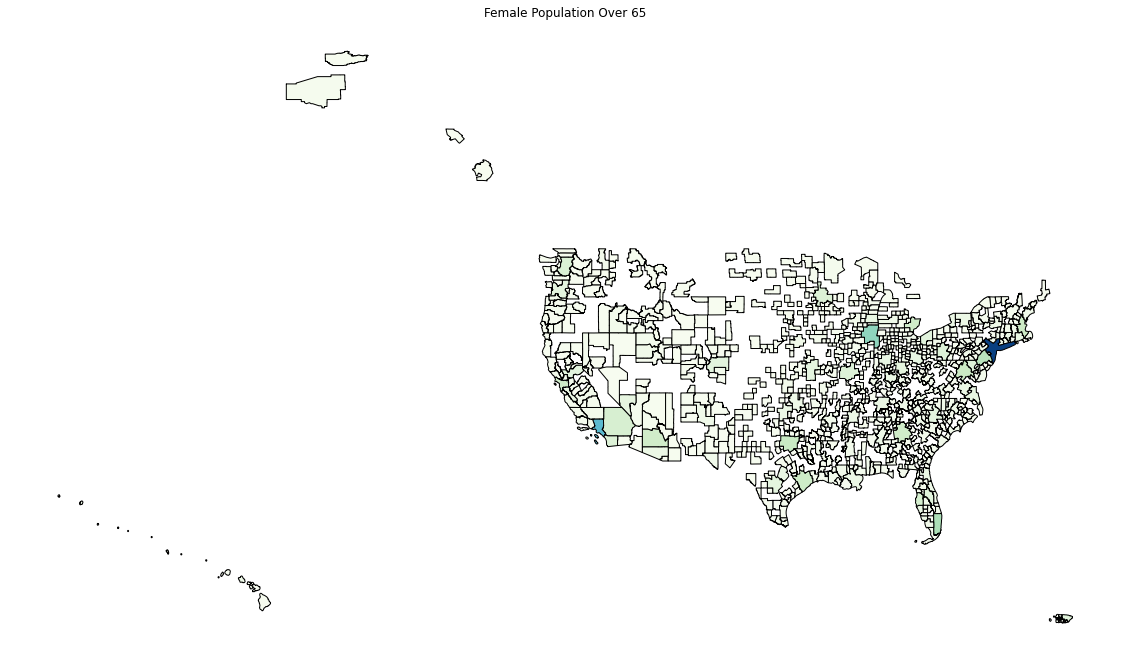

In [68]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'fo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Female Population Over 65', fontsize=12)
ax.axis('off');

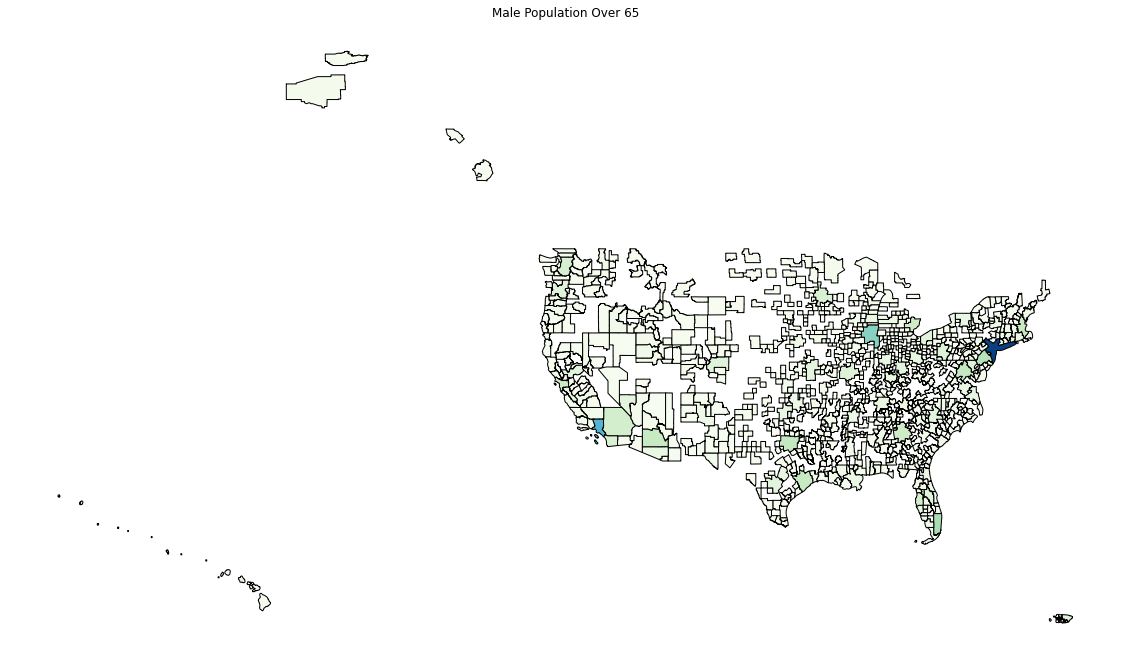

In [69]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'mo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Male Population Over 65', fontsize=12)
ax.axis('off');

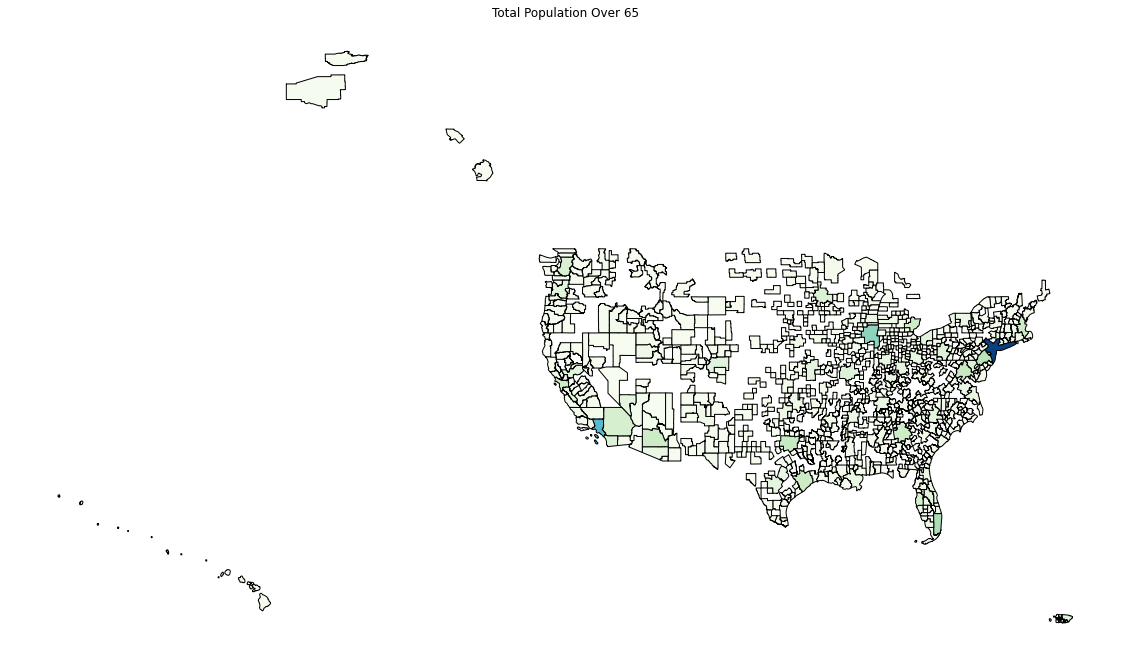

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'to65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Total Population Over 65', fontsize=12)
ax.axis('off');

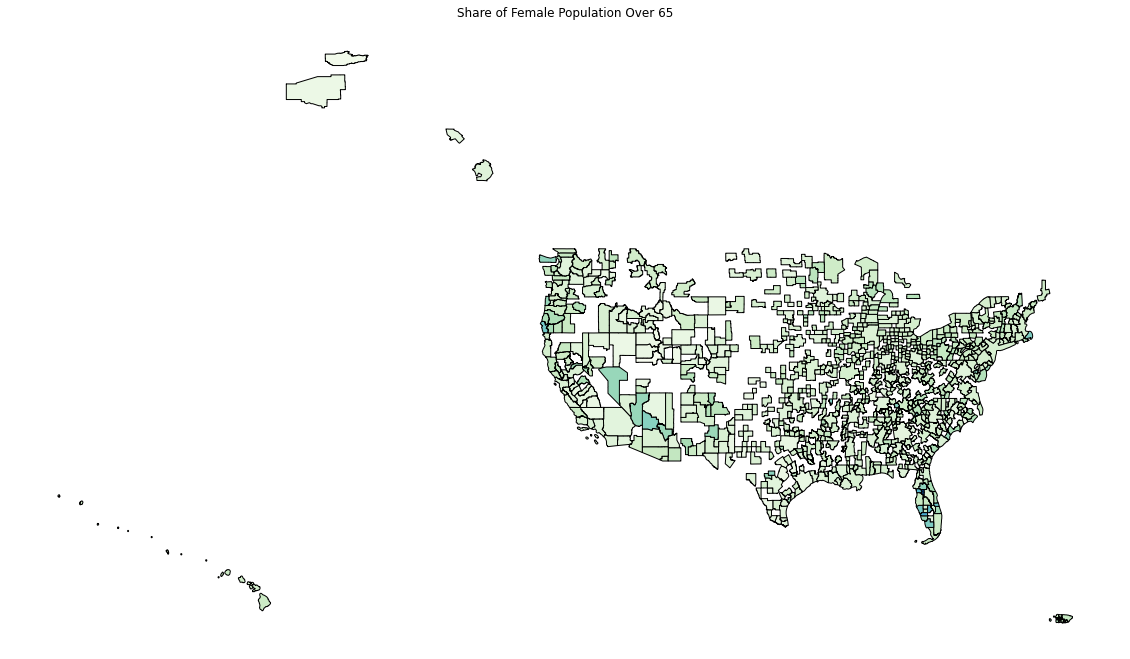

In [71]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pfo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Share of Female Population Over 65', fontsize=12)
ax.axis('off');

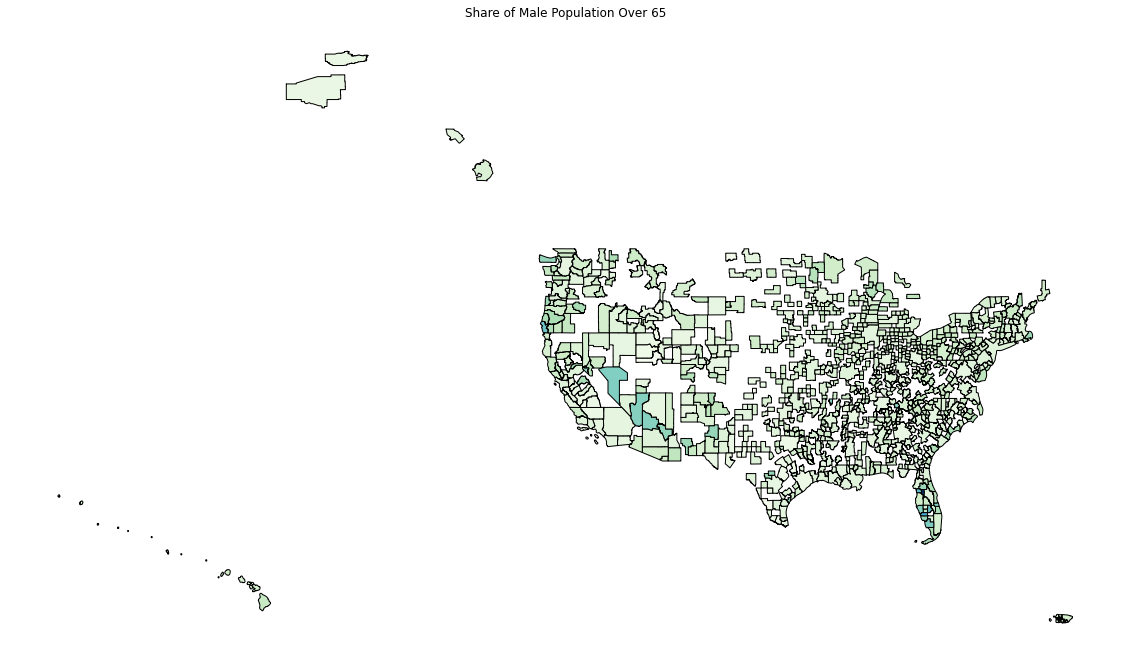

In [72]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pmo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Share of Male Population Over 65', fontsize=12)
ax.axis('off');

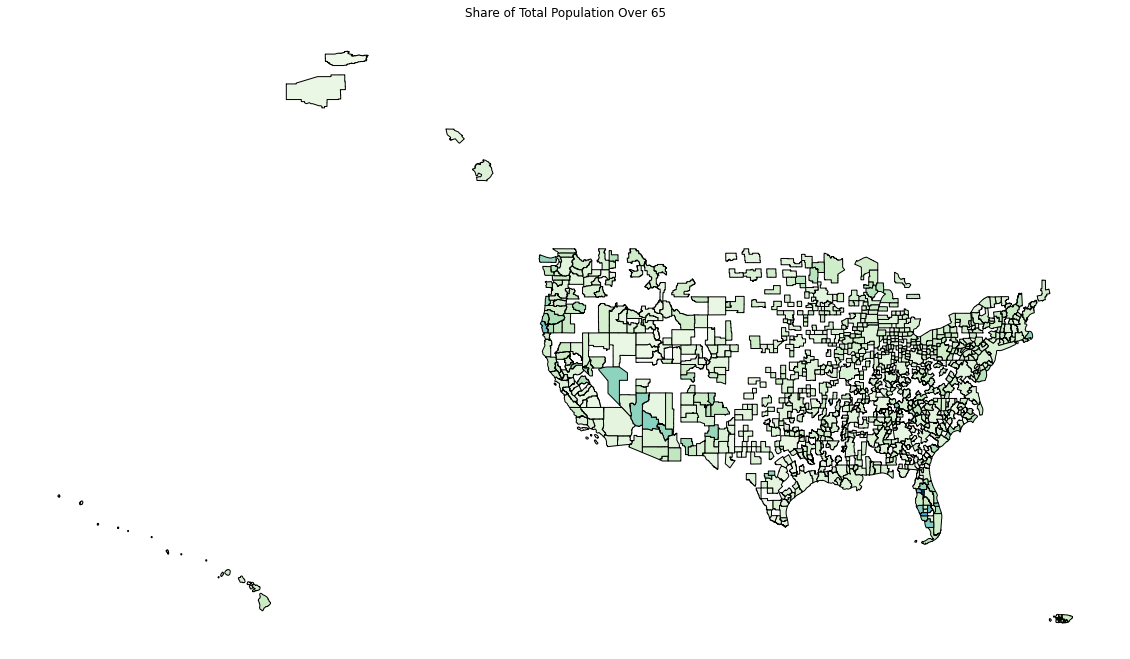

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pto65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Share of Total Population Over 65', fontsize=12)
ax.axis('off');